# Markov Decision Process

In the [previous notebook](https://github.com/Kiboya/Artificial-Intelligence-Notebooks/blob/2b0545ce5d1aceb5c2ae1f6f26348f565fef1504/Decision%20Making/Deterministic%20Environments/01_pathfinding_strategies.ipynb), we explored various pathfinding algorithms such as BFS, DFS, Dijkstra, and A*. These algorithms are effective for determining the shortest path from a start node to a goal node in static environments.

However, these traditional algorithms face challenges in dynamic or uncertain conditions where factors like randomness, incomplete information, and changing environments come into play. In real-world scenarios, the ability to adapt to such uncertainties is crucial for effective decision-making.

Markov Decision Processes (MDPs) offer a robust framework for modeling decision-making in these uncertain settings. By incorporating both rewards and the probabilities of different outcomes, MDPs enable the development of strategies that can adapt and make optimal decisions even when facing variability and unpredictability. This makes MDPs better for creating solutions that navigate complex, real-world environments effectively.

## Environment Setup

In this notebook, we will explore the concept of Markov Decision Processes (MDPs) and how they can be used to model decision-making in a grid-based environment similar to the one used in the pathfinding algorithms. Some new elements such as rewards, transitions are introduced to the environment and will be explained in detail as we progress.

Imagine our agent is navigating a 6x5 grid:

- **States:** Each cell in the grid represents a state. Some cells are walls (impassable), some are terminal states (once in it, the agent cannot move) with rewards (+1 or -1), and the rest have a small negative reward (-0.04) to encourage the agent to reach a terminal state quickly.
- **Actions:** The agent can move **Up**, **Down**, **Left**, or **Right**. However, movement is stochastic:
    - 80% chance to move in the intended direction.
    - 10% chance to veer to the left of the intended direction.
    - 10% chance to veer to the right of the intended direction.
- **Rewards:** Entering a terminal state gives a reward of +1 or -1. Moving to any other state incurs a small penalty of -0.04.

States: {(1, 2), (2, 1), (3, 1), (4, 3), (1, 1), (2, 3), (3, 3), (3, 2), (1, 3)}


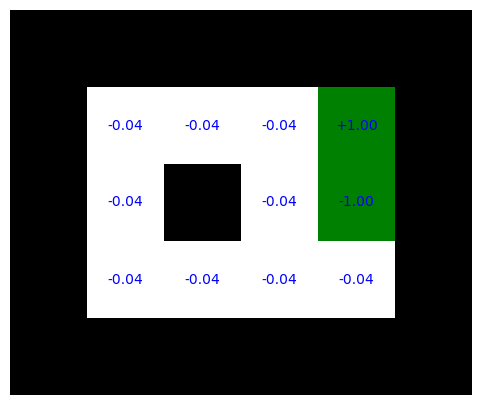

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

class World:
    def __init__(self, grid_width, grid_height):
        """
        Initialize the World environment.

        Args:
            grid_width (int): Width of the grid.
            grid_height (int): Height of the grid.
        """
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.walls = self._initialize_walls()
        self.terminal_nodes = {(4, 1): 1, (4, 2): -1}
        self.default_reward = -0.04
        self.states = self._initialize_states()
        self.rewards = self._initialize_rewards()
        self.actions = ['up', 'down', 'left', 'right']
        self.transition_probs = self._initialize_transition_probs()

    def _initialize_walls(self):
        """
        Initialize wall positions in the grid.

        Returns:
            set: Set of wall coordinates.
        """
        walls = set()
        for x in range(self.grid_width):
            walls.add((x, 0))
            walls.add((x, self.grid_height - 1))
        for y in range(self.grid_height):
            walls.add((0, y))
            walls.add((self.grid_width - 1, y))
        walls.add((2, 2))
        return walls

    def _initialize_states(self):
        """
        Initialize non-wall, non-terminal states.

        Returns:
            set: Set of state coordinates.
        """
        states = set()
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                if (x, y) not in self.walls:
                    states.add((x, y))
        states -= set(self.terminal_nodes.keys())
        print(f'States: {states}')
        return states

    def _initialize_rewards(self):
        """
        Initialize rewards for each state.

        Returns:
            dict: Mapping of state coordinates to rewards.
        """
        rewards = {}
        for state in self.states:
            rewards[state] = self.default_reward
        for state, reward in self.terminal_nodes.items():
            rewards[state] = reward
        return rewards

    def _initialize_transition_probs(self):
        """
        Initialize transition probabilities for each state and action.

        Returns:
            dict: Nested dictionary of transition probabilities.
        """
        transition_probs = {}
        for state in self.states | set(self.terminal_nodes.keys()):
            transition_probs[state] = {}
            for action in self.actions:
                transition_probs[state][action] = self._calculate_move_probabilities(state, action)
        return transition_probs

    def _calculate_move_probabilities(self, state, action):
        """
        Calculate move probabilities based on action.

        Args:
            state (tuple): Current state coordinates.
            action (str): Action to take.

        Returns:
            dict: Mapping of next states to probabilities.
        """
        dxdy = {'up': (0, -1), 'down': (0, 1), 'left': (-1, 0), 'right': (1, 0)}
        left_right = {'up': ('left', 'right'), 'down': ('right', 'left'), 'left': ('down', 'up'), 'right': ('up', 'down')}
        intended = dxdy[action]
        left = dxdy[left_right[action][0]]
        right = dxdy[left_right[action][1]]

        moves = {
            intended: 0.8,
            left: 0.1,
            right: 0.1
        }

        probabilities = {}
        for move, prob in moves.items():
            new_state = (state[0] + move[0], state[1] + move[1])
            # If the new state is a wall, stay in the same state
            if new_state in self.states or new_state in self.terminal_nodes:
                probabilities[new_state] = probabilities.get(new_state, 0) + prob
            else:
                probabilities[state] = probabilities.get(state, 0) + prob

        return probabilities

    def step(self, action):
        """
        Take a step in the environment based on the action.

        Args:
            action (str): Action to perform.

        Returns:
            tuple: Next state and reward.
        """
        if action not in self.actions:
            raise ValueError("Invalid action")
        probs = self.transition_probs[self.current_state][action]
        next_state = random.choices(list(probs.keys()), weights=probs.values())[0]
        reward = self.rewards.get(next_state, 0)
        self.current_state = next_state
        return next_state, reward

    def display(self, path=None, display_rewards=True, policy=None):
        """
        Display the grid world.

        Args:
            path (list, optional): List of state coordinates representing a path.
            display_rewards (bool, optional): Whether to display rewards.
            policy (dict, optional): Policy mapping states to actions.
        """
        grid = np.zeros((self.grid_height, self.grid_width))

        for x in range(self.grid_width):
            for y in range(self.grid_height):
                if (x, y) in self.walls:
                    grid[y, x] = 0
                elif (x, y) in self.terminal_nodes:
                    grid[y, x] = 1
                else:
                    grid[y, x] = 2

        cmap = ListedColormap(['black', 'green', 'white'])
        bounds = [0, 1, 2, 3]
        norm = BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(6, 5))
        plt.imshow(grid, cmap=cmap, norm=norm)

        if display_rewards:
            for state, reward in self.rewards.items():
                x, y = state
                plt.text(x, y, f'{reward:+.2f}', ha='center', va='center', color='blue')

        if policy:
            arrows = {'up': '\u2191', 'down': '\u2193', 'left': '\u2190', 'right': '\u2192'}
            for state, action in policy.items():
                x, y = state
                plt.text(x, y, arrows[action], ha='center', va='center', color='red')

        if path:
            path_x, path_y = zip(*path)
            plt.plot(path_x, path_y, marker='o', color='red')

        plt.axis('off')
        plt.show()

    def set_rewards(self, new_rewards):
        """
        Update rewards for states.

        Args:
            new_rewards (dict): Mapping of state coordinates to new rewards.
        """
        self.rewards.update(new_rewards)

    def get_transitions(self, state, action):
        """
        Retrieve transitions for a given state and action.

        Args:
            state (tuple): The current state.
            action (str): The action to evaluate.

        Returns:
            list: List of tuples (probability, next_state, reward).
        """
        transitions = []
        for next_state, prob in self.transition_probs[state][action].items():
            reward = self.rewards.get(next_state, self.default_reward)
            transitions.append((prob, next_state, reward))
        return transitions

world_env = World(grid_width=6, grid_height=5)
world_env.display()


## Markov Decision Process

Markov Decision Processes (MDPs) provide a mathematical framework for modeling decision-making in environments where outcomes are partly random and partly under the control of a decision maker. 

### Components of an MDP

An MDP is defined by the following components:

1. **States (S):** A finite set of states representing all possible configurations of the environment. In our grid-based environment, each cell corresponds to a unique state.

2. **Actions (A):** A set of actions available to the agent. In our setup, the agent can perform actions such as moving up, down, left, or right.

3. **Transition Probabilities (P):** The probability of transitioning from one state to another given a particular action. Due to the stochastic nature of the environment, actions may not always lead to the intended state. For example, there is a 10% chance the agent moves left or right relative to the intended direction.

4. **Rewards (R):** A reward function that assigns a numerical value to each state (or state-action pair). Rewards indicate the immediate benefit or cost of entering a particular state. In our environment, each cell has an associated reward that the agent receives upon entering it.

5. **Policy (π):** A strategy that specifies the action the agent should take in each state to maximize cumulative rewards over time. It is basically a lookup table that takes the current state as input and returns the action to be taken.

### Objective

The primary objective in an MDP is to determine an optimal policy that maximizes the expected sum of rewards the agent receives over time. This involves balancing immediate rewards with future rewards to achieve long-term success.

### Solving MDPs

In this notebook, we will explore various algorithms for solving MDPs and deriving optimal policies. These algorithms include:

- **Value Iteration:** Iteratively updates the value of each state until convergence, then derives the optimal policy based on these values.

- **Policy Iteration:** Alternates between evaluating the current policy and improving it until it becomes optimal.

- **Q-Learning:** A model-free reinforcement learning algorithm that learns the value of actions directly without needing a model of the environment.

## Value Iteration

Value Iteration is a fundamental algorithm used to determine the optimal policy for an agent aiming to maximize its cumulative rewards in a MDP. It systematically updates the value of each state by considering the expected rewards and transition probabilities, enabling the agent to make informed decisions that lead to the best long-term outcomes.

### Bellman's Equation

Bellman's equation provides a recursive relationship for updating the value of a state based on the values of its neighboring states until convergence. 

$$
V(s) = \max_{a \in A} \left[ R(s) + \gamma \sum_{s'} P(s'|s,a) V(s') \right]
$$

Where:
- $ V(s) $ is the value of state $ s $.
- $ A $ is the set of possible actions.
- $ R(s) $ is the immediate reward for being in state $ s $.
- $ \gamma $ is the discount factor. This factor determines the importance of future rewards relative to immediate rewards. A higher discount factor values future rewards more highly.
- $ P(s'|s,a) $ is the probability of transitioning to state $ s' $ from state $ s $ when action $ a $ is taken.

### Applying Value Iteration to our Grid Environment

In our grid-based environment, each cell represents a state, and the agent can perform actions such as **Up**, **Down**, **Left**, or **Right** with stochastic outcomes.

For testing, we are using a discount factor ($\gamma$) of 0.99 and a convergence threshold ($\epsilon$) of 0.01.

Here’s how Value Iteration is applied in this context:

1. **Initialize State Values:**
    - Assign an initial value (e.g., 0) to all states in `world_env.states`.

2. **Iterative Update:**
    - For each state $ s $ in `world_env.state`, compute the value $ V(s) $ using Bellman's equation by considering all possible actions and their probabilistic outcomes as defined in `world_env.transition_probs`.

3. **Convergence:**
    - Repeat the update process until the changes in state values are less than a predefined threshold (here, $\epsilon = 0.01$) indicating the values have stabilized.

4. **Derive Optimal Policy:**
    - After convergence, determine the best action for each state by selecting the action that maximizes the expected value based on the updated state values.


In [16]:
def value_iteration(world, discount_factor=0.9, epsilon=0.01):
    """
    Perform Value Iteration to compute the optimal value function and policy for the given world environment.

    Args:
        world (World): The MDP environment containing states, actions, transition probabilities, and rewards.
        discount_factor (float): The discount factor gamma, representing the importance of future rewards.
        theta (float): A threshold for determining the convergence of the value function.

    Returns:
        tuple: A tuple containing the value function dictionary V and the optimal policy dictionary policy.
    """
    V = {state: 0 for state in world.states} # V is the value function 
    print("States:", world.states)

    # Iterate for each state to update the value function until convergence
    while True:
        delta = 0  # Initialize the maximum change in the value function 
        for state in world.states:
            if state in world.terminal_nodes:
                print(state)
                continue  # Skip terminal states as their values do not change since they have no successors
            action_values = [] # Initialize the list to store the expected values of all possible actions
            for action in world.actions:
                # Calculate the expected value for each action
                value = sum(
                    prob * (reward + discount_factor * V[next_state])
                    for prob, next_state, reward in world.get_transitions(state, action)
                )
                action_values.append(value)
            max_value = max(action_values)  # Select the maximum value among all possible actions
            delta = max(delta, abs(max_value - V[state]))  # Update delta to track the maximum change
            V[state] = max_value  # Update the value of the current state
        if delta < epsilon:
            # If the maximum change is below the threshold, the algorithm has converged
            break

    # Derive the optimal policy for each state based on the computed value function
    policy = {}
    for state in world.states:
        if state in world.terminal_nodes:
            policy[state] = None  # No action for terminal states
            continue
        best_action, max_value = None, float('-inf')
        for action in world.actions:
            # Compute the expected value of taking this action
            value = sum(
                prob * (reward + discount_factor * V[next_state])
                for prob, next_state, reward in world.get_transitions(state, action)
            )
            if value > max_value:
                best_action, max_value = action, value
        policy[state] = best_action  # Assign the best action to the current state
    return V, policy


In [17]:
# Call the value_iteration function
value_function, optimal_policy = value_iteration(world_env, discount_factor=0.9, epsilon=0.01)

# Print the results
print("Optimal Value Function:")
for state, value in value_function.items():
    print(f"State {state}: {value}")

print("\nOptimal Policy:")
for state, action in optimal_policy.items():
    print(f"State {state}: {action}")

States: {(1, 2), (2, 1), (3, 1), (4, 3), (1, 1), (2, 3), (3, 3), (3, 2), (1, 3)}


KeyError: (4, 1)